In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
# Import stratifiedKFold
from sklearn.model_selection import KFold

In [41]:
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_numeric_dtype
def scale_data(data):
    data = data.copy()
    scaler = StandardScaler()
    for col in data.columns:
        if is_numeric_dtype(data[col]):
            data[col] = scaler.fit_transform(data[[col]])
    return data

In [42]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
b = [1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9, 12.0]
c = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
d = [object, object, object, object, object, object, object, object, object, object]
data = {'a': a, 'b': b, 'c': c, 'd': d}
df = pd.DataFrame(data)
df = scale_data(df)
df

,a,b,c,d
0,-1.57,-1.52,a,<class 'object'>
1,-1.22,-1.19,b,<class 'object'>
2,-0.87,-0.86,c,<class 'object'>
3,-0.52,-0.53,d,<class 'object'>
4,-0.17,-0.20,e,<class 'object'>
5,0.17,0.14,f,<class 'object'>
6,0.52,0.47,g,<class 'object'>
7,0.87,0.80,h,<class 'object'>
8,1.22,1.13,i,<class 'object'>
9,1.57,1.76,j,<class 'object'>


In [43]:
def cross_validate_model(model, X, y):
    cv_strat = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_validate(model, X, y, cv=cv_strat, scoring=['neg_root_mean_squared_error'], return_train_score=True, return_estimator=True)
    return cv_results

In [44]:
def average_cv_results(cv_results):
    avg_results = {}
    print(cv_results.keys())
    for key in cv_results.keys():
        if key == 'estimator':
            continue
        avg_results[key] = cv_results[key].mean()
    # Get best estimator according to RMSE
    best_estimator_index = cv_results['test_neg_root_mean_squared_error'].argmax()
    best_estimator = cv_results['estimator'][best_estimator_index]
    return avg_results, best_estimator

In [45]:
def lazy_model(df, target, drop_cols=[]):
    from lazypredict.supervised import LazyRegressor
    X = df.drop(columns=[target] + drop_cols)
    X = X.drop(columns=X.select_dtypes('datetimetz').columns)
    print(X.info())
    y = df[target]
    X = scale_data(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)
    return models

In [46]:
def feature_importance(model, X, y):
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        feature_importances = pd.DataFrame(model.feature_importances_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    elif hasattr(model, 'coef_'):
        feature_importances = pd.DataFrame(model.coef_,
                                       index = X.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)
    else:
        print('Model does not have feature importances')
    return feature_importances

In [47]:
def average_feature_importance(models, X, y):
    feature_importances = []
    for model in models:
        feature_importances.append(feature_importance(model, X, y))
    avg_importances = pd.concat(feature_importances).groupby(level=0).mean().sort_values('importance', ascending=False)
    return avg_importances[:10]


In [48]:
def lime_regression(model, X_train, X_test, y_train, y_test):
    import lime
    import lime.lime_tabular
    explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='regression', training_labels=y_train.values, feature_names=X_train.columns)

    exp = explainer.explain_instance(X_test.values[0], model.predict, num_features=len(X_train.columns))
    return exp

In [49]:
def shap_values(model, X):
    import shap
    shap.initjs()
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return shap_values

In [50]:
# Load the data from pkl
cf = pd.read_pickle('../../data/processed/cf_mc_ino_pino_of_bt_ct.pkl')
# get object columns
object_cols = cf.select_dtypes(include='object').columns
object_cols

Index(['lote', 'lote_parental_cf', 'id_bio', 'id_centr', 'id_bio_ino',
       'orden'],
      dtype='object')

In [51]:

# Target is producto_1_cf
y = cf['producto_1_cf']
# Features are all columns except producto_1_cf
X = cf.drop(columns=['producto_1_cf'])
# Drop all columns which are not numeric
#X = X.select_dtypes(include=['number'])
drop_cols = ['producto_2_cf','lote', 'lote_parental_cf','id_bio', 'id_bio_ino', 'id_centr', 'orden']

X = X.drop(columns=drop_cols)
# If a column is datetime drop it
import numpy as np
X = X.drop(columns=X.select_dtypes('datetimetz').columns)
X.shape, y.shape

((152, 155), (152,))

In [52]:
# Find NATType
X.dtypes.value_counts()
# find object columns
object_cols = X.select_dtypes(include='object').columns
object_cols

Index([], dtype='object')

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Columns: 155 entries, orden_encadenado_cf to h_cent_th_cf
dtypes: float64(154), int64(1)
memory usage: 184.2 KB


In [54]:
def grid_search_random_forest(X, y):
    from sklearn.model_selection import GridSearchCV
    rf = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, 30, 35],
        'min_samples_split': [2, 5, 8, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['auto', 'sqrt', 'log2'],
        'random_state': [42]
    }
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)
    grid_search.fit(X, y)
    return grid_search

In [55]:
# Perform cross validation
# Scale
X = scale_data(X)

# Grid search
#grid_search = grid_search_random_forest(X, y)
#print(grid_search.best_params_)

In [56]:
# Perform cross validation
# Scale
# Select cols

X = scale_data(X)
model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=4, n_estimators=100, random_state=42)
cv_results = cross_validate_model(model, X, y)
avg_results, best_estimator = average_cv_results(cv_results)
print('test average RMSE:', avg_results['test_neg_root_mean_squared_error'])
print('train average RMSE:', avg_results['train_neg_root_mean_squared_error'])
print('best_estimator test RMSE:', cv_results['test_neg_root_mean_squared_error'].max())
print(feature_importance(best_estimator, X, y))
print(average_feature_importance(cv_results['estimator'], X, y))


dict_keys(['fit_time', 'score_time', 'estimator', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error'])
test average RMSE: -259.007037891576
train average RMSE: -117.85173036802703
best_estimator test RMSE: -164.71546723966404
                          importance
pres_par_O2_1_bt_cf             0.04
turb_fin_cultivo_cf             0.03
turbidez_diff_cf                0.03
turb_fin_cultivo_ino            0.02
dur_ino                         0.02
...                              ...
desc_total_ct_min_cf            0.00
desc_parcial_ct_last_cf         0.00
desc_parcial_ct_first_cf        0.00
desc_total_ct_first_cf          0.00
desc_total_ct_last_cf           0.00

[155 rows x 1 columns]
                         importance
pres_par_O2_1_bt_cf            0.04
turb_fin_cultivo_cf            0.03
turbidez_diff_cf               0.03
turb_fin_cultivo_ino           0.02
dur_ino                        0.02
pres_par_O2_1_bt_min_cf        0.02
centr_2_turb_cf                0.

In [57]:

lazy_model(cf, 'producto_1_cf', drop_cols=drop_cols)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Columns: 155 entries, orden_encadenado_cf to h_cent_th_cf
dtypes: float64(154), int64(1)
memory usage: 184.2 KB
None


 67%|██████▋   | 28/42 [00:02<00:01, 11.53it/s]

LassoLarsIC model failed to execute
You are using LassoLarsIC in the case where the number of samples is smaller than the number of features. In this setting, getting a good estimate for the variance of the noise is not possible. Provide an estimate of the noise variance in the constructor.
RANSACRegressor model failed to execute
`min_samples` may not be larger than number of samples: n_samples = 121.


100%|██████████| 42/42 [00:03<00:00, 13.89it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4003
[LightGBM] [Info] Number of data points in the train set: 121, number of used features: 138
[LightGBM] [Info] Start training from score 1672.990337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,14663718696171364580162106353008203678896866479...,-6109882790071402407481682464463164612489785266...,2022719163598029311754278797312.00,0.02
LinearRegression,5642.98,-23507.26,39676.14,0.05
TransformedTargetRegressor,5642.98,-23507.26,39676.14,0.03
Lasso,160.06,-661.74,6661.79,0.02
HuberRegressor,129.71,-535.30,5992.70,0.02
KernelRidge,124.80,-514.82,5877.18,0.01
Ridge,95.29,-391.87,5129.14,0.02
PassiveAggressiveRegressor,84.08,-345.16,4814.58,0.01
SGDRegressor,47.41,-192.37,3598.46,0.01


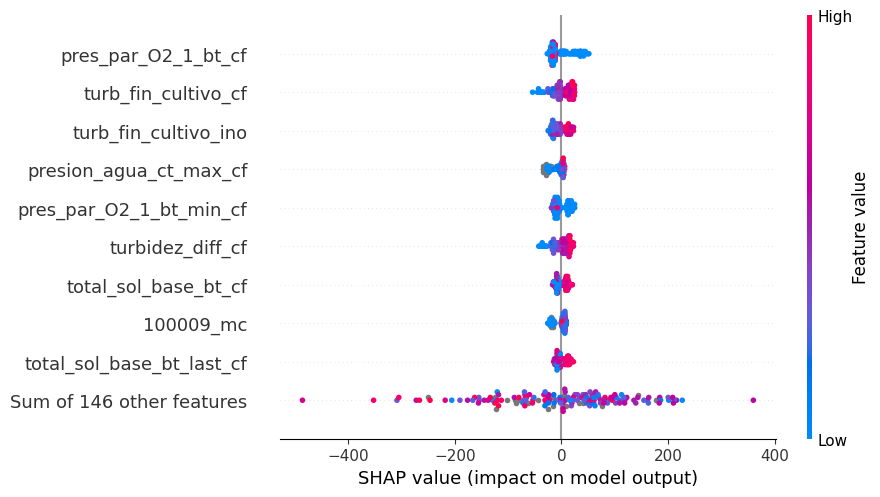

In [58]:
# shap
import shap
exp = shap_values(best_estimator, X)
shap.plots.beeswarm(exp)

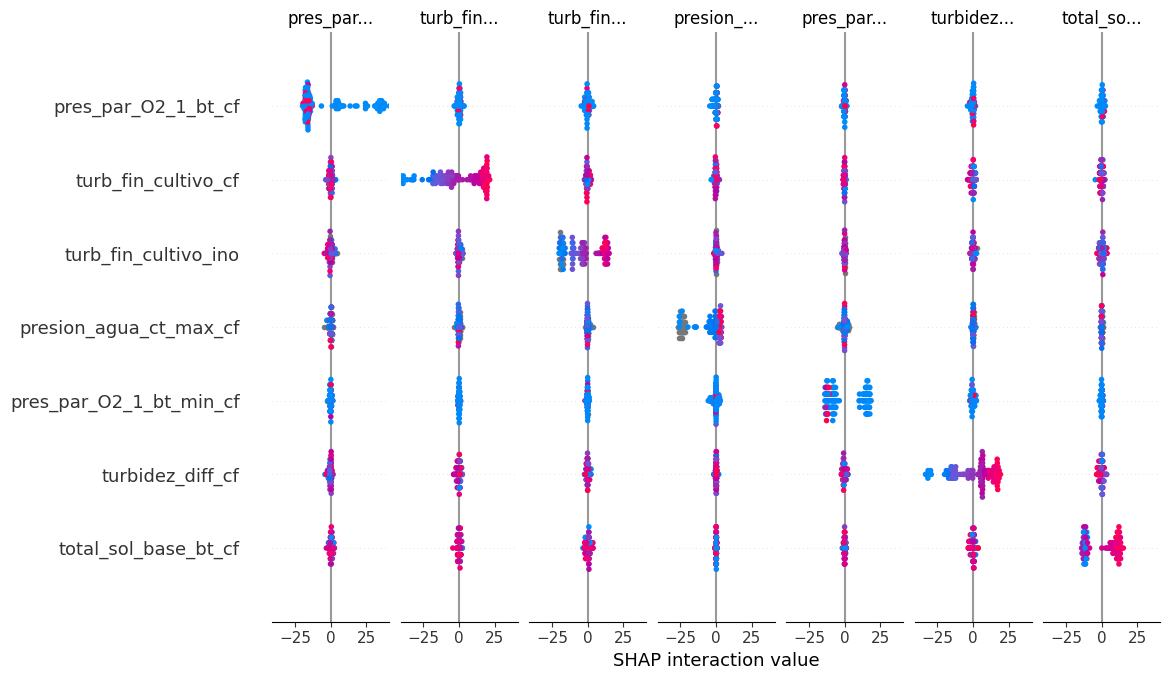

In [59]:
# Get interaction values
shap_interaction_values = shap.TreeExplainer(best_estimator).shap_interaction_values(X)
shap.summary_plot(shap_interaction_values, X)


In [60]:
# load test
cf_test = pd.read_pickle('../../data/processed/test_mc_ino_pino_of.pkl')
cf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Columns: 169 entries, lote to h_cent_th_cf
dtypes: datetime64[ns, UTC](6), float64(142), int64(2), object(19)
memory usage: 74.1+ KB


In [61]:
cf_test = cf_test.sort_values('lote', ascending=True).reset_index(drop=True)
# Save lote
lotes = cf_test['lote']
# Drop columns
drop_cols = ['producto_2_cf','lote', 'lote_parental_cf','id_bio' , 'id_centr']
cf_test = cf_test.drop(columns=drop_cols)
# Drop product_1_cf
cf_test = cf_test.drop(columns=['producto_1_cf'])
# Drop datetime columns
cf_test = cf_test.drop(columns=cf_test.select_dtypes('datetimetz').columns)

cf_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Columns: 157 entries, orden_encadenado_cf to h_cent_th_cf
dtypes: float64(140), int64(2), object(15)
memory usage: 68.8+ KB


In [62]:
# Train a model with all data
model = RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=8, n_estimators=50, random_state=42)
X = scale_data(X)
#X = X[features.index]
model.fit(X, y)


RandomForestRegressor(max_depth=20, max_features='sqrt', min_samples_split=8,
                      n_estimators=50, random_state=42)

In [68]:
# Scale
cf_test = scale_data(cf_test)
# Drop columns
cf_test = cf_test[X.columns]
# Predict
y_pred = model.predict(cf_test)

# Save predictions
predictions = pd.DataFrame({'lote': lotes, 'producto_1_cf': y_pred})
# Order by lote
predictions = predictions.sort_values('lote', ascending=True).reset_index(drop=True)
# Sep | without header
predictions.to_csv('../../data/processed/universityhack.predict', sep='|', header=False, index=False)